# Libraries and Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as adf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from tensorflow.keras.models import load_model

In [2]:

data = pd.read_csv('InvestmentReplica.CSV', header=0)
data = data.set_index('Date')
data.index = pd.to_datetime(data.index, dayfirst=True)

futures_list = ['RX1','TY1','GC1','CO1','ES1','VG1',
    'NQ1','LLL1','TP1','DU1', 'TU2' ]
indexes_list = ['MXWO','MXWD','LEGATRUU','HFRXGL']
indexes = data[indexes_list]
futures = data[futures_list]

# Data exploration
## Indexes data exploration

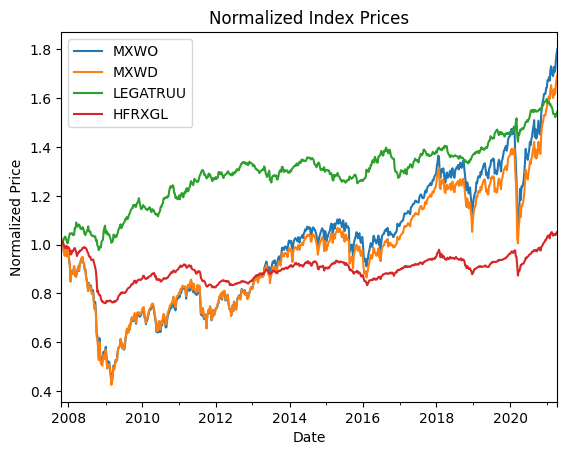

In [3]:

indexes_norm = indexes.div(indexes.iloc[0])
indexes_plot = indexes_norm.plot()
indexes_plot.set_ylabel('Normalized Price')
indexes_plot.set_xlabel('Date')
indexes_plot.set_title('Normalized Index Prices')
plt.show()

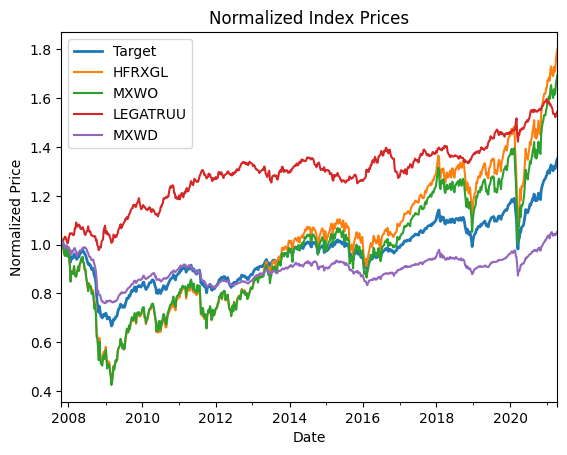

In [4]:

wHFRXGL = 0.5
wMXWO = 0.25
wLEGATRUU = 0.25
wMXWD = 0


target = wHFRXGL*indexes['HFRXGL'] + wMXWO*indexes['MXWO'] + \
    wLEGATRUU*indexes['LEGATRUU'] + wMXWD*indexes['MXWD']
target.columns = ['Target']


target_norm = target.div(target.iloc[0])
target_plot = target_norm.plot(lw=2)
indexes_norm.plot(ax=target_plot)
target_plot.set_ylabel('Normalized Price')
target_plot.set_xlabel('Date')
target_plot.set_title('Normalized Index Prices')
target_plot.legend(['Target','HFRXGL','MXWO','LEGATRUU','MXWD'])
plt.show()

## Futures data exploration

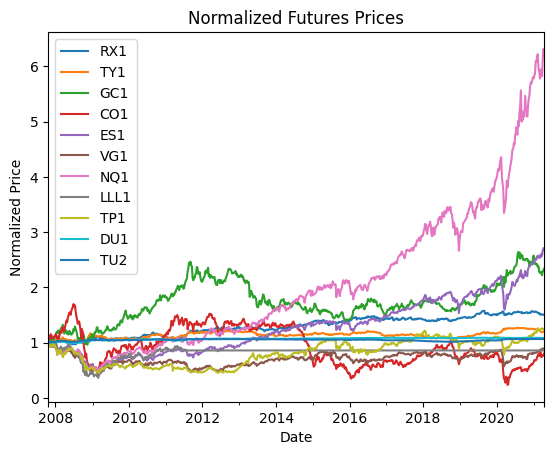

In [5]:

futures_norm = futures.div(futures.iloc[0])
futures_plot = futures_norm.plot()
futures_plot.set_ylabel('Normalized Price')
futures_plot.set_xlabel('Date')
futures_plot.set_title('Normalized Futures Prices')
plt.show()

In [6]:

futures_const = []
for i in range(len(futures.columns)):
    differences = futures.iloc[:,i].diff()
    if differences[differences==0].shape[0] > 100:
        futures_const.append(futures.columns[i])

futures = futures.drop(futures_const, axis=1)
futures.head()

,RX1,TY1,GC1,CO1,ES1,VG1,NQ1,TP1,DU1,TU2
Date,,,,,,,,,,
2007-10-23,113.70,110.516,759.0,82.85,1525.50,4393.0,2212.00,1570.5,103.385,103.719
2007-10-30,113.79,110.656,787.8,87.44,1536.00,4476.0,2217.75,1610.5,103.410,103.813
2007-11-06,113.79,110.875,823.4,93.26,1525.00,4425.0,2233.50,1575.5,103.410,104.047
2007-11-13,114.35,111.719,799.0,88.83,1483.25,4323.0,2066.75,1440.5,103.595,104.305
2007-11-20,114.72,113.156,791.4,95.49,1446.00,4296.0,2035.50,1472.5,103.800,104.945


# Data Stabilization
## Original target data

In [7]:

adf_result = adf(target)
print(f""" -- ADF Test --
ADF Statistic: {adf_result[0]}
p-value: {adf_result[1]}
Critical Values:
    1%: {adf_result[4]['1%']}
    5%: {adf_result[4]['5%']}
    10%: {adf_result[4]['10%']}
{ ' The time series is Stationary' if adf_result[0] < adf_result[4]['5%']
    else 'The time series is not Stationary'}
(with 95% confidence)
""")

 -- ADF Test --
ADF Statistic: 0.49514221713707746
p-value: 0.9847246976397238
Critical Values:
    1%: -3.4396861854831964
    5%: -2.865660062273053
    10%: -2.5689640195342456
The time series is not Stationary
(with 95% confidence)



## Returns of the target

In [8]:

target_returns = target.pct_change().dropna()


adf_result = adf(target_returns)
print(f""" -- ADF Test --
ADF Statistic: {adf_result[0]}
p-value: {adf_result[1]}
Critical Values:
    1%: {adf_result[4]['1%']}
    5%: {adf_result[4]['5%']}
    10%: {adf_result[4]['10%']}
{ ' The time series is Stationary' if adf_result[0] < adf_result[4]['5%']
    else 'The time series is not Stationary'}
(with 95% confidence)
""")

 -- ADF Test --
ADF Statistic: -22.220609380954766
p-value: 0.0
Critical Values:
    1%: -3.4396861854831964
    5%: -2.865660062273053
    10%: -2.5689640195342456
 The time series is Stationary
(with 95% confidence)



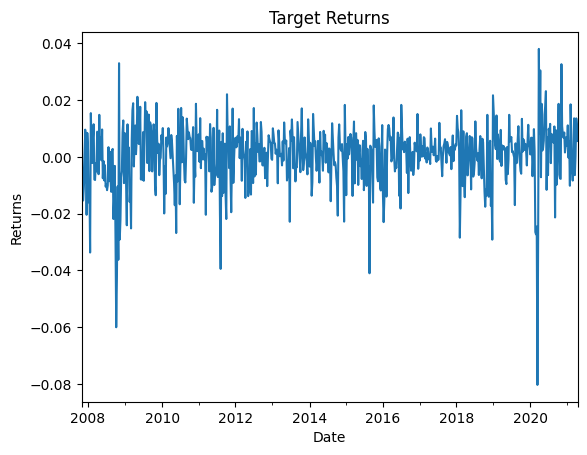

In [9]:

target_returns_plot = target_returns.plot()
target_returns_plot.set_ylabel('Returns')
target_returns_plot.set_xlabel('Date')
target_returns_plot.set_title('Target Returns')
plt.show()

As we can see this looks much more like a stationary time series.
Therefore we will use the returns in all of our models.  
Furthermore, the weights of the returns are linear and thus we can use them for
finacial evaluations.
## Original futures data

In [10]:

for future in futures:
    adf_result = adf(futures[future])
    print(
        f"{future:>4} -- {adf_result[0]:>5.2f}, {adf_result[1]:.2f} -- " \
        f"""{
            'Stationary' if adf_result[0] < adf_result[4]['5%']
            else 'Not Stationary'
        }"""
    )

 RX1 -- -1.26, 0.65 -- Not Stationary
 TY1 -- -2.66, 0.08 -- Not Stationary
 GC1 -- -1.60, 0.48 -- Not Stationary
 CO1 -- -2.47, 0.12 -- Not Stationary
 ES1 --  2.06, 1.00 -- Not Stationary
 VG1 -- -2.95, 0.04 -- Stationary
 NQ1 --  3.66, 1.00 -- Not Stationary
 TP1 -- -0.99, 0.76 -- Not Stationary
 DU1 -- -2.28, 0.18 -- Not Stationary
 TU2 -- -1.94, 0.32 -- Not Stationary


## Returns of the futures
Since we have used the returns of the target data, we will also try
to use the returns of the futures data.

In [11]:

futures_returns = futures.pct_change().dropna()

for future in futures_returns:
    adf_result = adf(futures_returns[future])
    print(
        f"{future:>4} -- {adf_result[0]:>6.2f}, {adf_result[1]:.2f} -- " \
        f"""{
            'Stationary' if adf_result[0] < adf_result[4]['5%']
            else 'Not Stationary'
        }"""
    )

 RX1 -- -20.92, 0.00 -- Stationary
 TY1 -- -27.29, 0.00 -- Stationary
 GC1 -- -28.04, 0.00 -- Stationary
 CO1 --  -8.95, 0.00 -- Stationary
 ES1 -- -19.58, 0.00 -- Stationary
 VG1 -- -20.43, 0.00 -- Stationary
 NQ1 -- -26.80, 0.00 -- Stationary
 TP1 -- -29.07, 0.00 -- Stationary
 DU1 --  -6.70, 0.00 -- Stationary
 TU2 --  -6.58, 0.00 -- Stationary


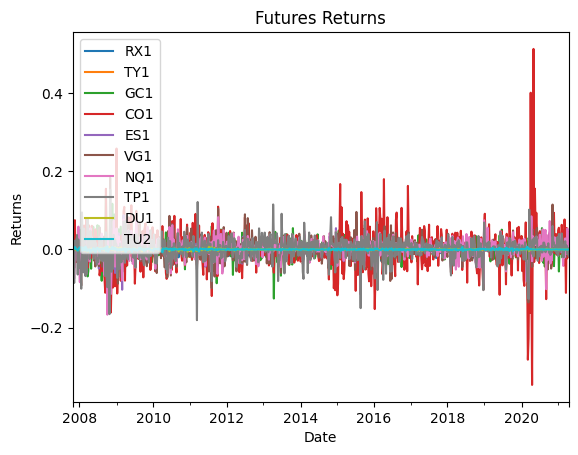

In [12]:

futures_returns_plot = futures_returns.plot()
futures_returns_plot.set_ylabel('Returns')
futures_returns_plot.set_xlabel('Date')
futures_returns_plot.set_title('Futures Returns')
plt.show()

As we can see, the returns of the futures are also stationary and we
can use it in our models to try and predict the target.

# Neural network models
We will test a few different types of neural networks to see which one performs
best.  
By using Neural Networks we aim to capture long-term, non linear relationships
between the target and the futures or rather, we aim to capture the non-linear
relationships between the futures and the weights of a replicating portfolio.  
This poses a challenge since we must train the neural network to predict the
weights of the replicating portfolio, not the target itself.  
We are forcing back linearity into the problem by using the replicating
portfolio weights as the target.  
First of all we performed a manual grid search to select the best parameters
such as the number of layers, the number of neurons per layer and the lookback
window.  
Our manual grid search showed that the best parameters are:
- 2 layers
- 52 weeks lookback window (1 year)
- 20 neurons per layer
- 32 batch size
- 100 epochs
- 0.01 learning rate

### Data preparation
We create the sliding window and split the data into train and test sets.

In [13]:


lookback = 52
train_pct = 0.8

x, y = futures_returns.values, target_returns.values
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y.reshape(-1, 1)).reshape(-1) 

num_features, num_obs_used = x.shape[1], x.shape[0] - lookback + 1

x_data, y_data = x[lookback-1:, :], y[lookback-1:]
sw_data = np.zeros((num_obs_used, lookback, num_features))
for i in range(num_obs_used): 
    sw_data[i, :, :] = x[i:i+lookback, :]


split_index = int(train_pct * num_obs_used)
sw_train, sw_test = sw_data[:split_index, :, :], sw_data[split_index:, :, :]
y_trainRNN, y_testRNN= y_data[:split_index], y_data[split_index:]
x_trainRNN, x_testRNN = x_data[:split_index, :], x_data[split_index:, :]

test_datesRNN = target_returns.index[split_index+lookback-1:]

print(f"""X_train shape: {x_trainRNN.shape}
SW_train shape: {sw_train.shape}
y_train shape: {y_trainRNN.shape}
X_test shape: {x_testRNN.shape}
y_test shape: {y_testRNN.shape}
SW_test shape: {sw_test.shape}""")

X_train shape: (522, 10)
SW_train shape: (522, 52, 10)
y_train shape: (522,)
X_test shape: (131, 10)
y_test shape: (131,)
SW_test shape: (131, 52, 10)


**Note:** Here we use z-scoring to rescale our data and make it nicer for our
neural networks to work with. One caveat is that by default both RNN's and
LSTM's use the tanh activation function, which has a range of (-1, 1). Thus, we
should rescale our data to be in the range of (-1, 1) or change the activation
function to something else like ReLU.

### Custom loss function
Since we are dealing with the replication of a portfolio we want to move with it
as much as possible while at the same time, being just as, if not more,
profitable.  
Our priority is not to lose with respect to the target.  
Since we are using returns, a negative returns is a loss, while a positive one
is a gain.  
We took the product of the sign of the prediction and the actual values as a
measure of whether they are moving in the same direction.
Hence we have 4 possible cases:
1. We are doing better than the target, and moving in the same direction.  
    This is very good, we are following the target and actually outperfoming
    it.   
    This should actually be incentivized.
2. We are doing better than the target but we are drifting off.
    This is not very good but neither bad, we aren't following the target anymore
    but at least we are outperfoming it.
3. We are doing worse than the portfolio but we are moving in the same direction.
    This is bad but not too bad. We are being outperformed from the target but
    at least we are following it.
4. We are doing worse than the portfolio and we are moving in the opposite direction.  
    This is the least desirable case. Not only are we being outperformed by the
    target, we are also not following it.  
We squared the errors and then weighted them from least sever to most severe.

In [14]:
def custom_loss(y_true, y_pred):


    sq_res = K.square(y_true - y_pred)

    case1 = sq_res[(y_pred >= y_true) & (y_true * y_pred >= 0)] * 0.5
    case2 = sq_res[(y_pred >= y_true) & (y_true * y_pred < 0)] * 1
    case3 = sq_res[(y_pred < y_true) & (y_true * y_pred >= 0)] * 1.5
    case4 = sq_res[(y_pred < y_true) & (y_true * y_pred < 0)] * 2

    sq_res = K.concatenate([case1, case2, case3, case4])
    
    return K.mean(sq_res)

### Model architecture and Hyperparameters
As we mentioned before, we performed a manual grid search to select the best
parameters.  
Hence, we create a RNN model with 2 layers, 20 neurons per layer and a lookback
window of 52 weeks.  
To relinearize the problem we use a Lambda layer to perform the dot product
between the weights and the futures.  

Model: "RNN_2x20x52"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sliding_window (InputLayer)    [(None, 52, 10)]     0           []                               
                                                                                                  
 rnn_1 (SimpleRNN)              (None, 52, 20)       620         ['sliding_window[0][0]']         
                                                                                                  
 rnn_2 (SimpleRNN)              (None, 20)           820         ['rnn_1[0][0]']                  
                                                                                                  
 futures_input (InputLayer)     [(None, 10)]         0           []                               
                                                                                        

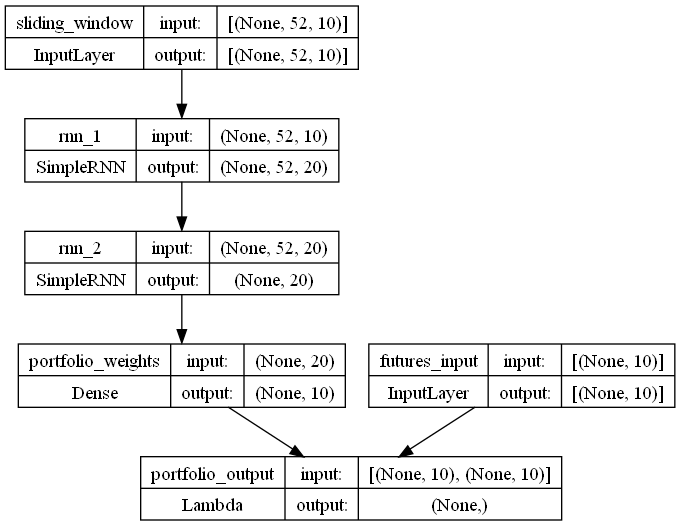

In [15]:

num_features = x_trainRNN.shape[1]
RNN_units = 20

input_layerRNN = Input(shape=(num_features,), name='futures_input')
sw_layer = Input(shape=(lookback, num_features),
    name='sliding_window')

rnn_layer1 = SimpleRNN(units=RNN_units, activation='relu', name='rnn_1',
    return_sequences=True)(sw_layer)
rnn_layer2 = SimpleRNN(units=RNN_units, activation='relu', name='rnn_2'
    )(rnn_layer1)

weights_layerRNN = Dense(units=num_features, activation='linear',
    name='portfolio_weights')(rnn_layer2)

output_layerRNN =  Lambda(
    lambda x: K.reshape(K.batch_dot(x[0], x[1], axes=1), (-1,)),
    name='portfolio_output')([input_layerRNN, weights_layerRNN])

modelRNN = Model(inputs=[input_layerRNN, sw_layer], outputs=output_layerRNN,
    name=f'RNN_2x{RNN_units}x{lookback}')

modelRNN.summary()
plot_model(modelRNN, show_shapes=True, show_layer_names=True)

In [17]:
lr = 0.01
batch_size = 32
epochs = 100

modelRNN.compile(optimizer=Adam(learning_rate=lr), loss=custom_loss)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
    restore_best_weights=True)

history = modelRNN.fit([x_trainRNN, sw_train], y_trainRNN, epochs=100,
    batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 43ms/step - loss: 1.7849 - val_loss: 0.2152
Epoch 2/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4758 - val_loss: 0.1479
Epoch 3/100
14/14 [==============================] - 0s 13ms/step - loss: 0.2196 - val_loss: 0.1329
Epoch 4/100
14/14 [==============================] - 0s 12ms/step - loss: 0.1552 - val_loss: 0.1249
Epoch 5/100
14/14 [==============================] - 0s 12ms/step - loss: 0.1326 - val_loss: 0.1131
Epoch 6/100
14/14 [==============================] - 0s 12ms/step - loss: 0.1212 - val_loss: 0.1155
Epoch 7/100
14/14 [==============================] - 0s 12ms/step - loss: 0.1125 - val_loss: 0.1131
Epoch 8/100
14/14 [==============================] - 0s 12ms/step - loss: 0.1038 - val_loss: 0.1067
Epoch 9/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0979 - val_loss: 0.1096
Epoch 10/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0943 - val_loss: 0.1121

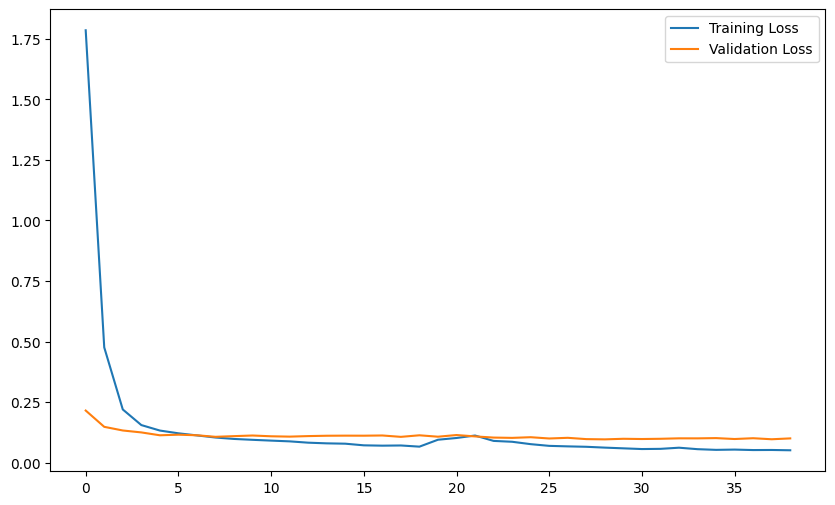

In [18]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Testing

5/5 [==============================] - 0s 3ms/step


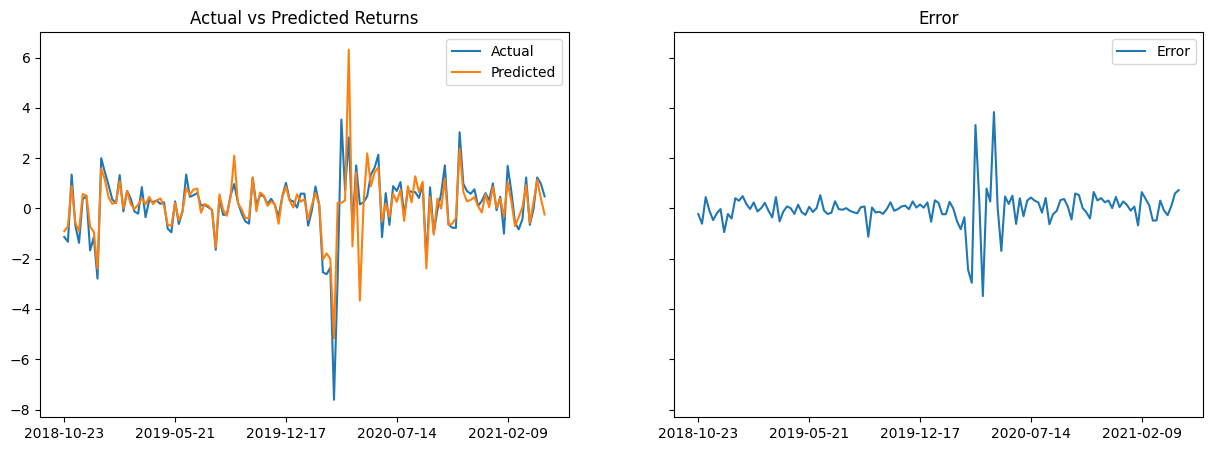

In [17]:

y_predRNN = modelRNN.predict([x_testRNN, sw_test])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.plot(test_datesRNN, y_testRNN, label='Actual')
ax1.plot(test_datesRNN, y_predRNN, label='Predicted')
ax1.legend()
ax1.set_title('Actual vs Predicted Returns')
ax2.plot(test_datesRNN, y_testRNN - y_predRNN, label='Error')
ax2.legend()
ax2.set_title('Error')

ax1.set_xticks(test_datesRNN[::30])
ax2.set_xticks(test_datesRNN[::30])
plt.show()

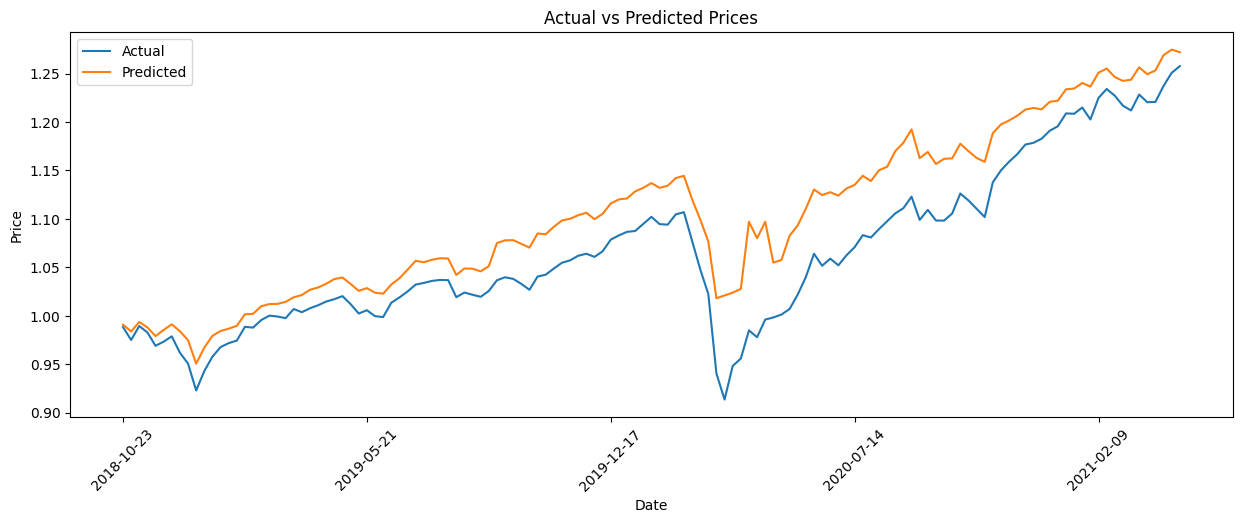

In [18]:

y_test_rescaledRNN = scaler.inverse_transform(
    y_testRNN.reshape(-1, 1)).reshape(-1)
y_pred_rescaledRNN = scaler.inverse_transform(
    y_predRNN.reshape(-1, 1)).reshape(-1)

price_testRNN = np.cumprod(1 + y_test_rescaledRNN)
price_predRNN = np.cumprod(1 + y_pred_rescaledRNN)

plt.figure(figsize=(15, 5))
plt.plot(test_datesRNN, price_testRNN, label='Actual')
plt.plot(test_datesRNN, price_predRNN, label='Predicted')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.xticks(test_datesRNN[::30], rotation=45)
plt.show()

As we can see, even a simple RNN is able to predict the target on the test set
fairly accurately and to capture the long-term relationship between the futures
and the weights to replicate the target.  
We may now perform a grid search of the hyperparameters to find the best
combination of parameters for the RNN.  
Furthermore we may introduce a dropout layer to prevent overfitting which this 
model may be prone to, given how we have split the data.  
Now we will also evaluate the model on a battery of metrics to evaluate it
against the other models.

In [19]:

MSE_RNN = MSE(y_test_rescaledRNN, y_pred_rescaledRNN)
print(f'MSE: {MSE_RNN}')

teRNN = y_test_rescaledRNN - y_pred_rescaledRNN
print(f'Tracking Error Volatility: {np.std(teRNN)*np.sqrt(52)}')

irRNN = np.mean(teRNN) / np.std(teRNN)
print(f'Information Ratio: {irRNN}')

MSE: 6.0808357866838286e-05
Tracking Error Volatility: 0.05622975804769039
Information Ratio: -0.008872842778618


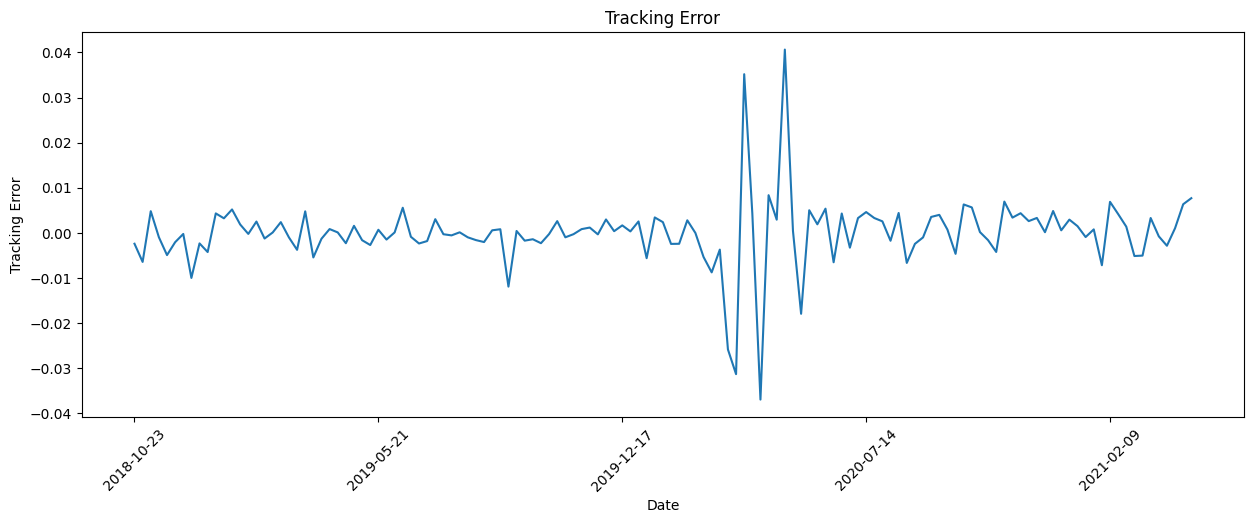

In [20]:

plt.figure(figsize=(15, 5))
plt.plot(test_datesRNN, teRNN)
plt.title('Tracking Error')
plt.xlabel('Date')
plt.ylabel('Tracking Error')
plt.xticks(test_datesRNN[::30], rotation=45)
plt.show()

As we can see the RNN even though it performs rather well in terms of loss, MSE
and MAE, it perform rather poorly from a feasability standpoint.  
As we can gleam from the Gross Exposure, we would be overexposed to the market
for most of the time.

## LSTM RNN
We now try to improve the performance of the RNN by using a Long Short Term
Memory (LSTM) RNN.  
Since we are trying to compare the performance of the RNN and the LSTM RNN, we
will use the same architecture as before, with the only difference being the
type of RNN used.  
Let us note that here we are not giving the model a predetermined number of
lags, but rather it is learning the number of lags to use by itself.  
For more details read [here](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)
## Data preparation
The data has already been rescaled, we just need to split it into training and
testing sets since here we will use the whole set of observations to train and 
test the model.  
Since we want the model to remember its past states, we need make it stateful,
hence we need to fix the batch size and make all the samples divisible by the batch
size.

In [39]:
# Let's get the quotient and remainder of the division between the number of
# observations and the batch size
quotient, remainder = x.shape[0] // batch_size, x.shape[0] % batch_size

if remainder: x, y = x[:-remainder, :], y[:-remainder] 

train_index = int(0.75 * quotient) * batch_size
val_index = int(0.9 * quotient) * batch_size
x_trainLSTM, y_trainLSTM = x[:train_index, :], y[:train_index]
x_valLSTM, y_valLSTM = x[train_index:val_index, :], y[train_index:val_index]
x_testLSTM, y_testLSTM = x[val_index:, :], y[val_index:]


num_timesteps = 1
x_trainLSTM = x_trainLSTM.reshape(-1, num_timesteps, num_features)
x_valLSTM = x_valLSTM.reshape(-1, num_timesteps, num_features)
x_testLSTM = x_testLSTM.reshape(-1, num_timesteps, num_features)


test_datesLSTM = target_returns.index[val_index:]

print(f"""X_train shape: {x_trainLSTM.shape}
y_train shape: {y_trainLSTM.shape}
X_val shape: {x_valLSTM.shape}
y_val shape: {y_valLSTM.shape}
X_test shape: {x_testLSTM.shape}
y_test shape: {y_testLSTM.shape}""")

X_train shape: (512, 1, 10)
y_train shape: (512,)
X_val shape: (96, 1, 10)
y_val shape: (96,)
X_test shape: (96, 1, 10)
y_test shape: (96,)


We have gained 52 observations but more importantly here we have no
overlap between the test and training sets.  
This is quite important since LSTM are prone to overfitting and we don't want
our model to be learning from noise.
### Model architecture

Model: "LSTM_2x20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 futures_input (InputLayer)     [(32, 1, 10)]        0           []                               
                                                                                                  
 lstm_6 (LSTM)                  (32, 1, 20)          2480        ['futures_input[0][0]']          
                                                                                                  
 lstm_7 (LSTM)                  (32, 1, 20)          3280        ['lstm_6[0][0]']                 
                                                                                                  
 portofolio_weights (Dense)     (32, 1, 10)          210         ['lstm_7[0][0]']                 
                                                                                          

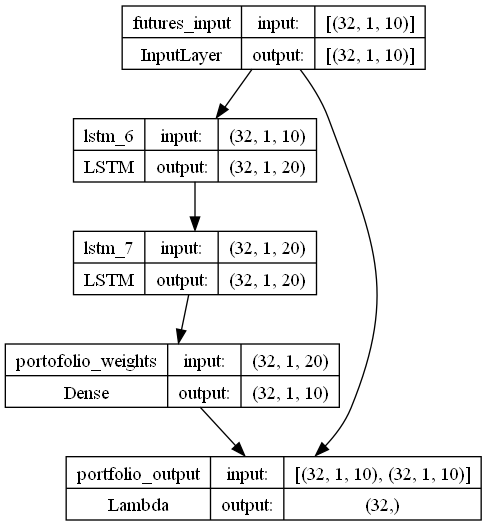

In [47]:
LSTM_units = 20

input_layerLSTM = Input(
    batch_input_shape=(batch_size, num_timesteps, num_features),
    name='futures_input')
lstm_layer1 = LSTM(units=LSTM_units, stateful=True,
    input_shape=(batch_size, num_features, num_timesteps),
    return_sequences=True, activation='relu')(input_layerLSTM)
lstm_layer2 = LSTM(units=LSTM_units, stateful=True,
    input_shape=(batch_size, num_features, num_timesteps),
    return_sequences=True, activation='relu')(lstm_layer1)
weights_layerLSTM = Dense(units=num_features, activation='linear',
    name='portofolio_weights')(lstm_layer2)
output_layerLSTM =  Lambda(
    lambda x: K.reshape(K.batch_dot(x[0], x[1], axes=2), (-1,)),
    name='portfolio_output'
    )([input_layerLSTM, weights_layerLSTM])

model = Model(inputs=input_layerLSTM, outputs=output_layerLSTM,
    name=f'LSTM_2x{LSTM_units}')

model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

### Training and compiling

In [48]:

model.compile(optimizer=Adam(learning_rate=0.01), loss=custom_loss)

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
    restore_best_weights=True)


history = model.fit(x_trainLSTM, y_trainLSTM, epochs=epochs,
    batch_size=batch_size, validation_data=(x_valLSTM, y_valLSTM),
    callbacks=[early_stop], verbose=2, shuffle=False)

Epoch 1/100
16/16 - 2s - loss: 0.5249 - val_loss: 0.3234 - 2s/epoch - 116ms/step
Epoch 2/100
16/16 - 0s - loss: 0.2349 - val_loss: 0.1328 - 50ms/epoch - 3ms/step
Epoch 3/100
16/16 - 0s - loss: 0.2081 - val_loss: 0.1659 - 51ms/epoch - 3ms/step
Epoch 4/100
16/16 - 0s - loss: 0.1520 - val_loss: 0.1024 - 44ms/epoch - 3ms/step
Epoch 5/100
16/16 - 0s - loss: 0.1541 - val_loss: 0.1376 - 45ms/epoch - 3ms/step
Epoch 6/100
16/16 - 0s - loss: 0.1343 - val_loss: 0.0958 - 43ms/epoch - 3ms/step
Epoch 7/100
16/16 - 0s - loss: 0.1597 - val_loss: 0.1505 - 43ms/epoch - 3ms/step
Epoch 8/100
16/16 - 0s - loss: 0.1327 - val_loss: 0.1031 - 48ms/epoch - 3ms/step
Epoch 9/100
16/16 - 0s - loss: 0.1560 - val_loss: 0.1105 - 44ms/epoch - 3ms/step
Epoch 10/100
16/16 - 0s - loss: 0.1231 - val_loss: 0.1052 - 45ms/epoch - 3ms/step
Epoch 11/100
16/16 - 0s - loss: 0.1236 - val_loss: 0.0929 - 48ms/epoch - 3ms/step
Epoch 12/100
16/16 - 0s - loss: 0.1117 - val_loss: 0.1190 - 48ms/epoch - 3ms/step
Epoch 13/100
16/16 - 0s -

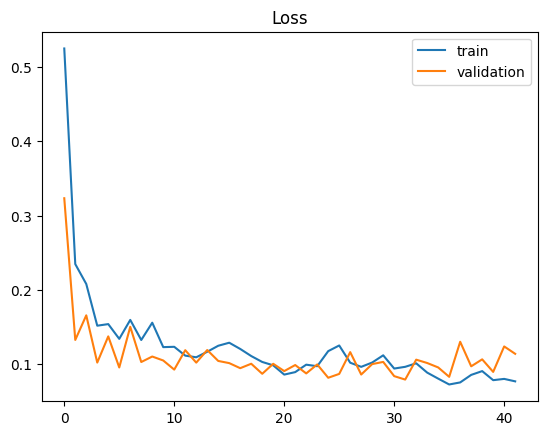

In [50]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

### Testing

3/3 [==============================] - 0s 2ms/step


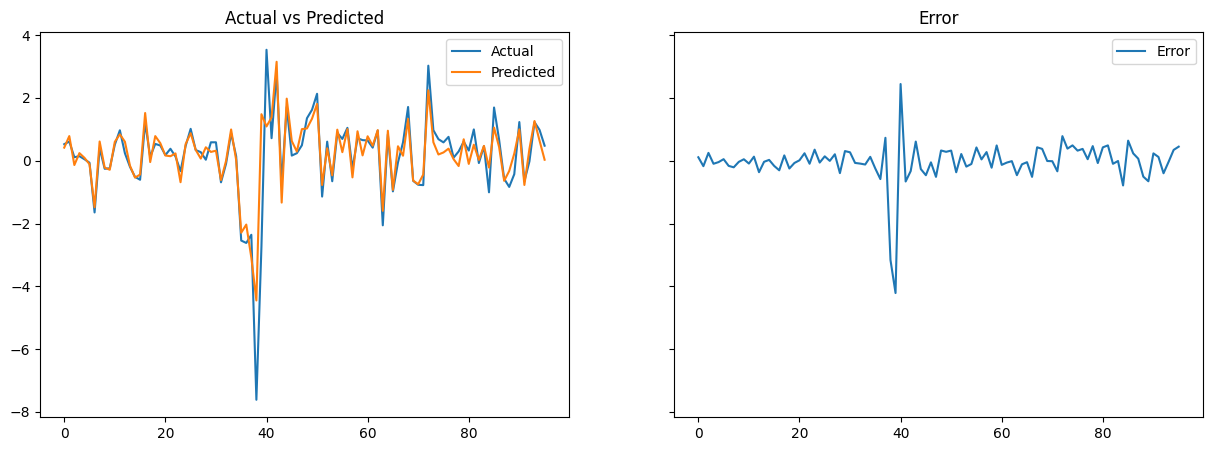

In [51]:
y_predLSTM = model.predict(x_testLSTM)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.plot(y_testLSTM, label='Actual')
ax1.plot(y_predLSTM, label='Predicted')
ax1.legend()
ax1.set_title('Actual vs Predicted')
ax2.plot(y_testLSTM - y_predLSTM, label='Error')
ax2.legend()
ax2.set_title('Error')
plt.show()

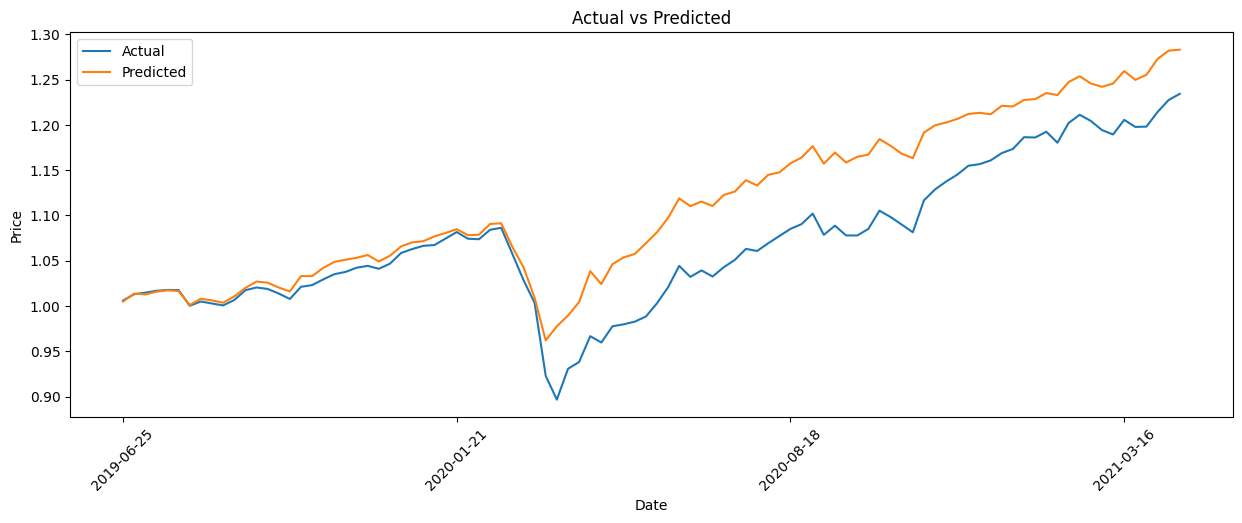

In [52]:

y_test_rescaledLSTM = scaler.inverse_transform(y_testLSTM.reshape(-1, 1)).reshape(-1)
y_pred_rescaledLSTM = scaler.inverse_transform(y_predLSTM.reshape(-1, 1)).reshape(-1)

price_testLSTM = np.cumprod(1 + y_test_rescaledLSTM)
price_predLSTM = np.cumprod(1 + y_pred_rescaledLSTM)

plt.figure(figsize=(15, 5))
plt.plot(test_datesLSTM, price_testLSTM, label='Actual')
plt.plot(test_datesLSTM, price_predLSTM, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.xticks(test_datesLSTM[::30], rotation=45)
plt.show()

As we can see, the LSTM performs better than the RNN in terms of being able to
follow the target and being more profitable.  
Let us now evaluate the model on a battery of metrics to evaluate it against the
other models.

In [53]:

MSE_LSTM = MSE(y_test_rescaledLSTM, y_pred_rescaledLSTM)
print(f'MSE: {MSE_LSTM}')

teLSTM = y_test_rescaledLSTM - y_pred_rescaledLSTM
print(f'Tracking Error: {np.std(teLSTM) * np.sqrt(52)}')

irLSTM = np.mean(teLSTM) / np.std(teLSTM)
print(f'Information Ratio: {irLSTM}')

MSE: 5.105996324520889e-05
Tracking Error: 0.05146099099212309
Information Ratio: -0.05098681630090558


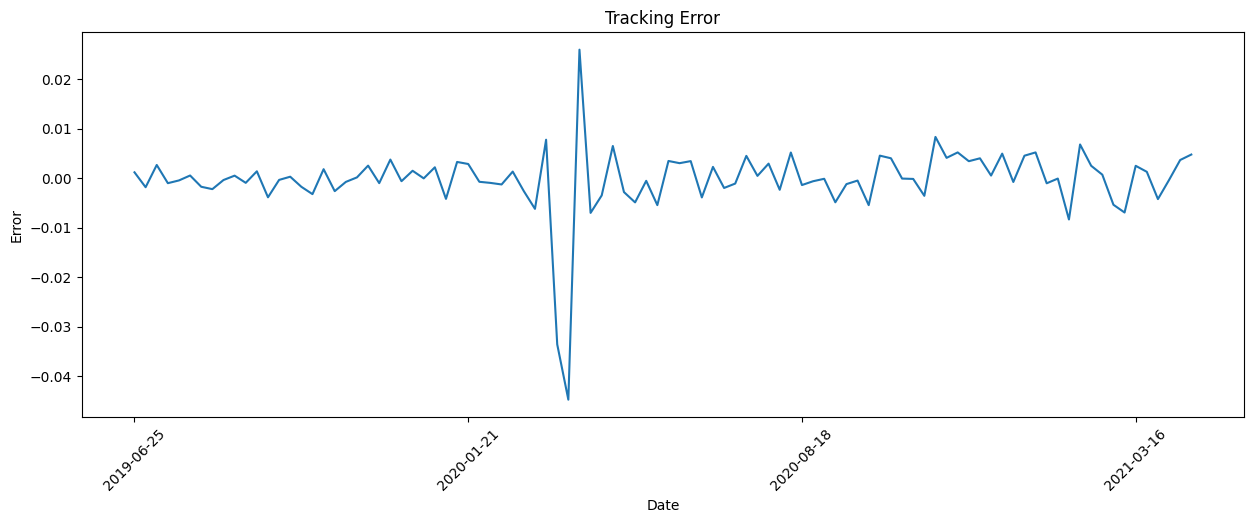

In [54]:

plt.figure(figsize=(15, 5))
plt.plot(test_datesLSTM, teLSTM)
plt.title('Tracking Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.xticks(test_datesLSTM[::30], rotation=45)
plt.show()

How can we pass from weighing the returns to weighing the futures directly?
We have the following formula:

$$
\begin{align*}
    \tau_t &= \sum_{i=1}^n w_{i,t} \phi_{i,t} \\
\end{align*}
$$
where $\tau$ is the normalized return of the target and $\phi$ is the normalized
return of futures $i$.  
We can rewrite this as:

$$
\begin{align*}
    \tau_t = \sum_{i=1}^n v_{i,t} x_{i,t} \\
    v_i = w_i \frac{\phi_{i,t}}{x_{i,t}}
\end{align*}
$$

where $x$ is the non normalized return of future $i$. We can further rewrite
this as:

$$ y_t = \sum_{i=1}^n \sigma_y v_{i,t} x_{i,t} + \mu_y $$

where $y$ is the non normalized return of the target and $\sigma_y$ and $\mu_y$
are the standard deviation and mean of the non normalized returns of the target
respectively.

Let us now write the returns as a function of the prices:

$$
\begin{align*}
    y_t &= \frac{T_t - T_{t-1}}{T_{t-1}} \\
    x_{i,t} &= \frac{F_{i,t} - F_{i,t-1}}{F_{i,t-1}}
\end{align*}
$$

where $T$ is the price of the target and $F_i$ is the price of future $i$.

We can now rewrite the formula as:

$$
\begin{align*}
    & \frac{T_t - T_{t-1}}{T_{t-1}} = \sum_{i=1}^n
        \sigma_y v_{i,t} \frac{F_{i,t} - F_{i,t-1}}{F_{i,t-1}} + \mu_y \\
    & \rightarrow T_t = T_{t-1} \left(1 + \mu_y - \sum_{i=1}^n \sigma_y v_{i,t}
        \right) + \sum_{i=1}^n \omega_{i,t} F_{i,t} \\
\end{align*}
$$
where $\omega_{i,t} = T_{t-1} \sigma_y v_{i,t}$.
The interpretation of this formula is not readibily available, but we can sketch
an explanation.  
The first term is comprised of one plus the mean return of the target minus the
sum of the weights of the retuns of the futures, this can be thought of as the
mean return of the target adjusted for the fact that we are using futures to 
replicate it, while the second term is the sum of the weights of the futures 
times the price of the futures, these new weights can be analized as the
influence of the futures on the target return.  
As we can see getting rid of the first term and thus arriving at a formula of
the form:
$$ T_t = \sum_{i=1}^n \omega_{i,t} F_{i,t} $$
is very hard (if not impossible) and how to pass from theory to practice is not
clear.